##Importing Libraries

In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#Initial Analisis

In [112]:
# Reading and slight cleaning of data
df = pd.read_csv("Sunspots.csv")
df = df.rename(columns={'Monthly Mean Total Sunspot Number': 'SunspotNumber'})
df.drop(columns = 'Unnamed: 0',inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3265 non-null   object 
 1   SunspotNumber  3265 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.1+ KB


#For better time series manipulation, let's convert the ‘Date’ column to datetime format and change its order

In [113]:
df = pd.read_csv("Sunspots.csv")
df.drop(columns='Unnamed: 0', inplace=True)
df.drop(index=df[df["Monthly Mean Total Sunspot Number"] == 0].index, inplace=True)
df.columns = ["Date", "Sunspot"]
df['Date'] = pd.to_datetime(df['Date'])



#Set the 'Date' column as the index of the DataFrame

In [114]:
df = df.set_index("Date")
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3198 entries, 1749-01-31 to 2021-01-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Sunspot  3198 non-null   float64
dtypes: float64(1)
memory usage: 50.0 KB


#Summary statistics

In [115]:
df.describe()

,Sunspot
count,3198.000000
mean,83.492089
std,67.545921
min,0.200000
25%,26.200000
50%,70.050000
75%,124.150000
max,398.200000


#Time indices are already sorted from past to present in an ascending order, and none of the values in the 'Monthly Mean Total Sunspot Number' column are null

In [116]:
print(df.index.is_monotonic_increasing)
df.isnull().sum()

True


Sunspot    0
dtype: int64

# Remove rows with zero sunspot values

In [117]:
df.drop(index=df[df["Sunspot"] == 0].index,inplace=True)


##Exploratory Data Analysis

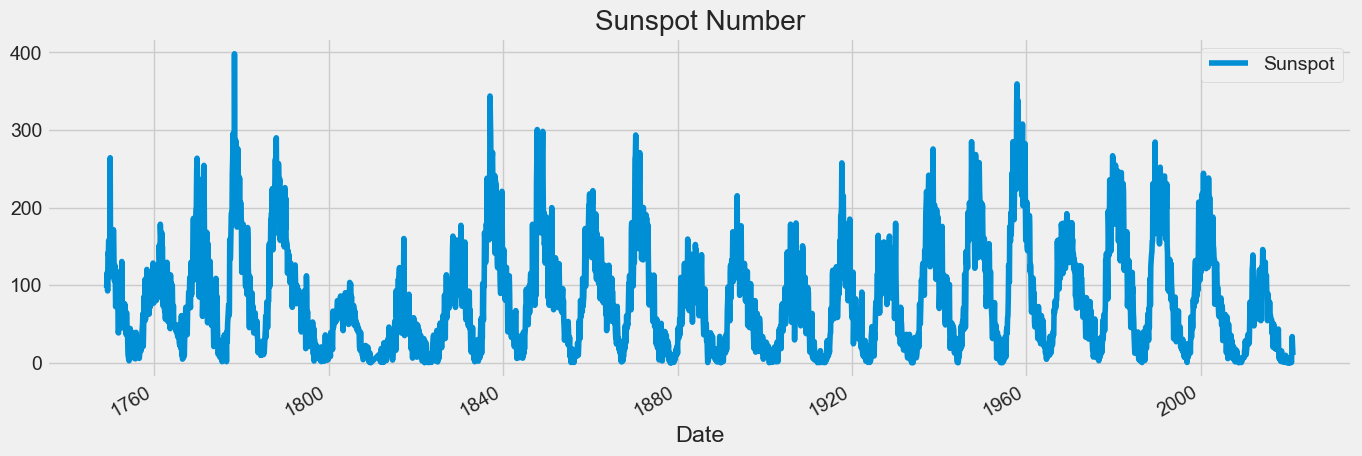

In [118]:
df.plot(style='-',
        figsize=(15, 5),
        color=color_pal[0],
        title='Sunspot Number')
plt.show()

#Graph showing data for all years

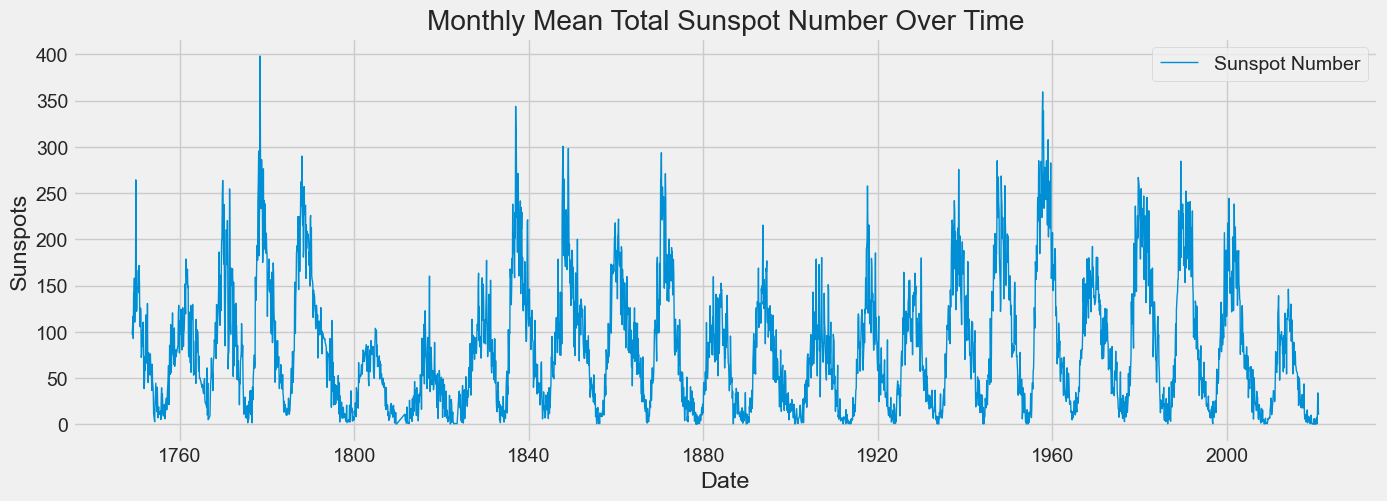

In [119]:
plt.figure(figsize=(15,5))
plt.plot(df.index, df["Sunspot"], label="Sunspot Number", linewidth=1)
plt.title("Monthly Mean Total Sunspot Number Over Time")
plt.xlabel("Date")
plt.ylabel("Sunspots")
plt.legend()
plt.grid(True)
plt.show()




#Graphs for the 11-year period 1880-1920

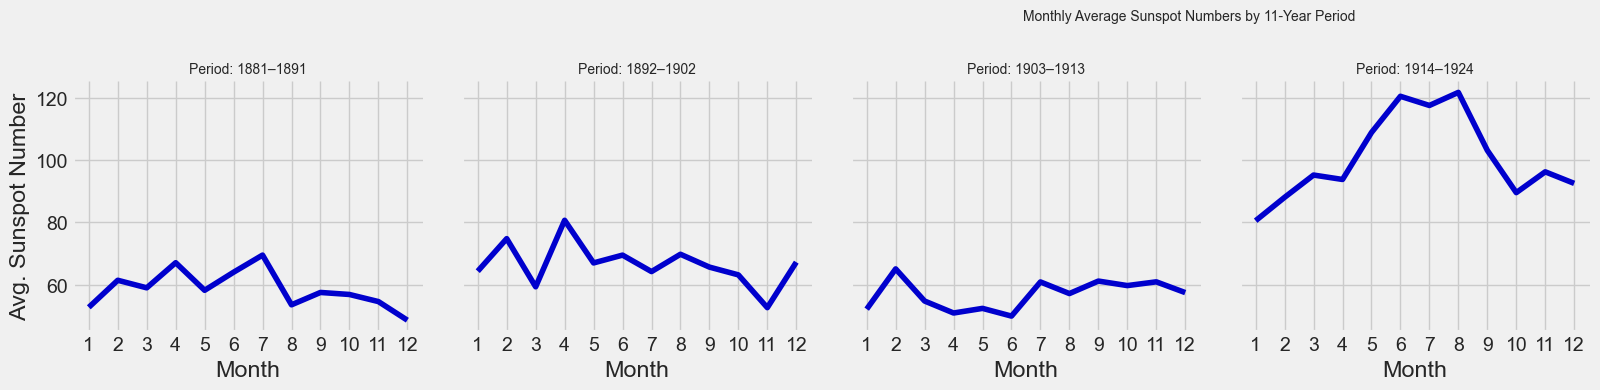

In [120]:

# Focus on data from 1880 to 1920
df_recent = df[(df.index.year > 1880) & (df.index.year < 1920)].copy()
df_recent['Year'] = df_recent.index.year
df_recent['Month'] = df_recent.index.month

# Create 11-year period labels (e.g., 1881, 1892, 1903)
df_recent['Period'] = (df_recent['Year'] // 11) * 11

# Calculate average sunspot number per month for each 11-year period
df_grouped = df_recent.groupby(['Period', 'Month'])['Sunspot'].mean().reset_index()

# Plot using Seaborn FacetGrid
g = sns.FacetGrid(df_grouped, col="Period", col_wrap=6, height=4, aspect=1)
g.map(sns.lineplot, "Month", "Sunspot", color="mediumblue")
g.set_axis_labels("Month", "Avg. Sunspot Number")
g.set(xticks=range(1, 13))
g.set_titles(col_template="{col_name}")
# Customize facet titles to show "Period: 1881–1891", etc.
for ax, period in zip(g.axes.flat, g.col_names):
    ax.set_title(f"Period: {int(period)}–{int(period)+10}", fontsize=10)

plt.subplots_adjust(top=0.8)
g.fig.suptitle("Monthly Average Sunspot Numbers by 11-Year Period", fontsize=10)
plt.show()

#Heat graph of sunspots over the last 30 years

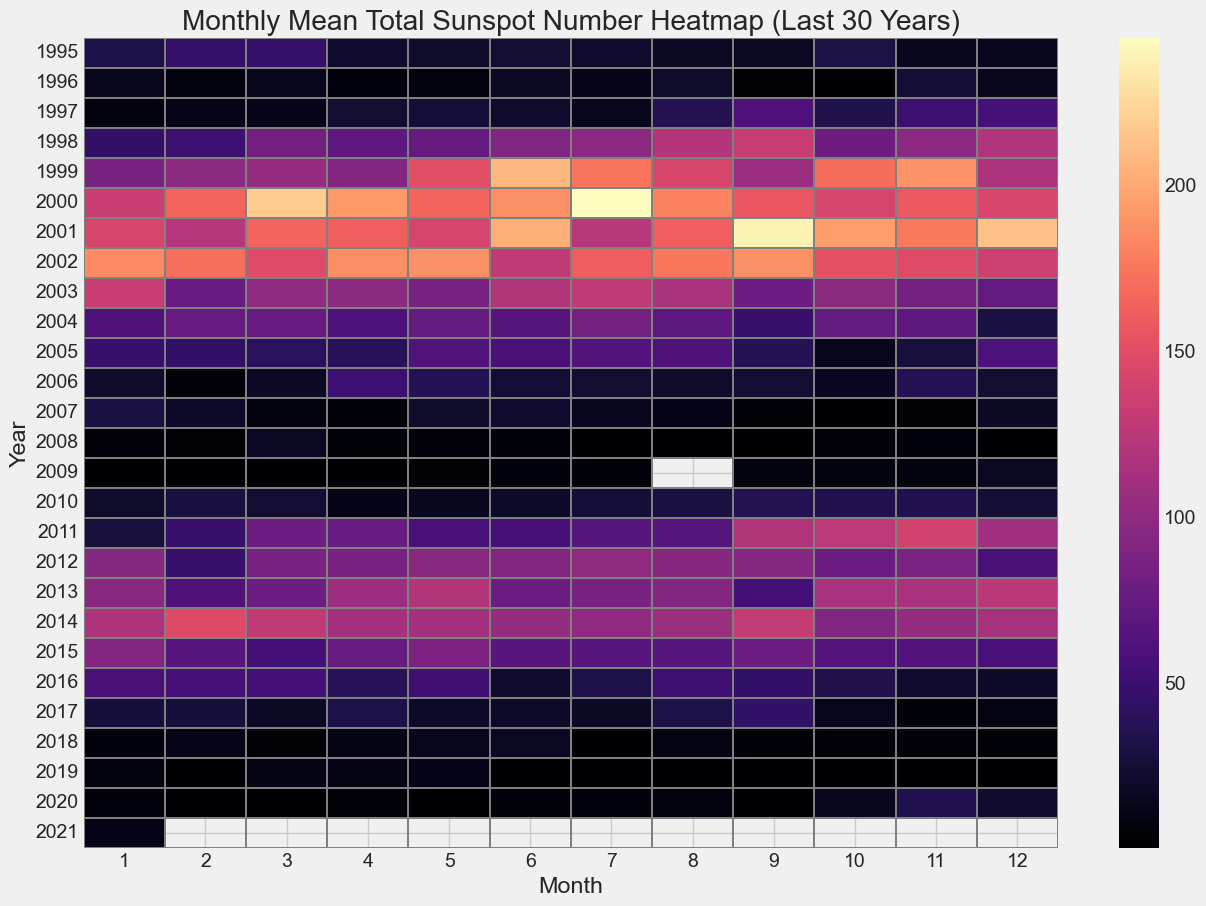

In [121]:
from datetime import datetime

if 'Year' not in df.columns or 'Month' not in df.columns:
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    
current_year = datetime.now().year
last_30_years = current_year - 30
df1_recent = df[df['Year'] >= last_30_years]
heatmap_data = df1_recent.pivot_table(
    index="Year",
    columns="Month",
    values="Sunspot",
    aggfunc="mean"
)
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap="magma", linewidths=0.1, linecolor='gray')
plt.title("Monthly Mean Total Sunspot Number Heatmap (Last 30 Years)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

#Comparison graph of monthly average sunspot number between 1985-1996 and 1996-2007

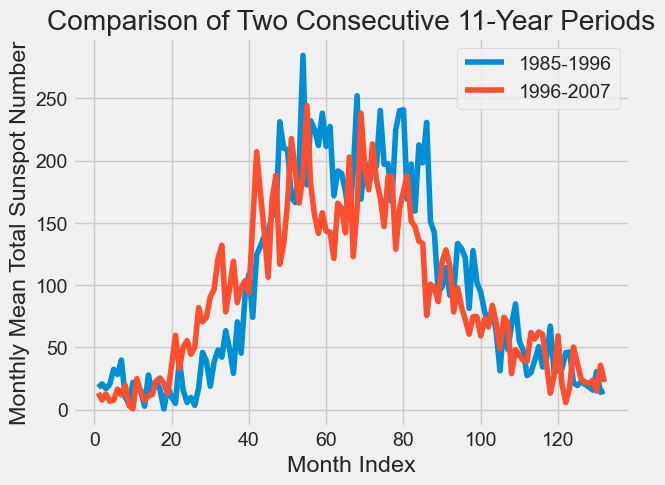

In [122]:
# Compare two consecutive 11-year periods
df_11_1985 = df[(df.index.year >= 1985) & (df.index.year < 1996)]
df_11_1996 = df[(df.index.year >= 1996) & (df.index.year < 2007)]

x_1985 = np.arange(1, len(df_11_1985) + 1)
x_1996 = np.arange(1, len(df_11_1996) + 1)

plt.plot(x_1985, df_11_1985['Sunspot'], label='1985-1996')
plt.plot(x_1996, df_11_1996['Sunspot'], label='1996-2007')
plt.legend()
plt.xlabel('Month Index')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.title('Comparison of Two Consecutive 11-Year Periods')
plt.show()

#Shows  sunspot averages for all years(year)

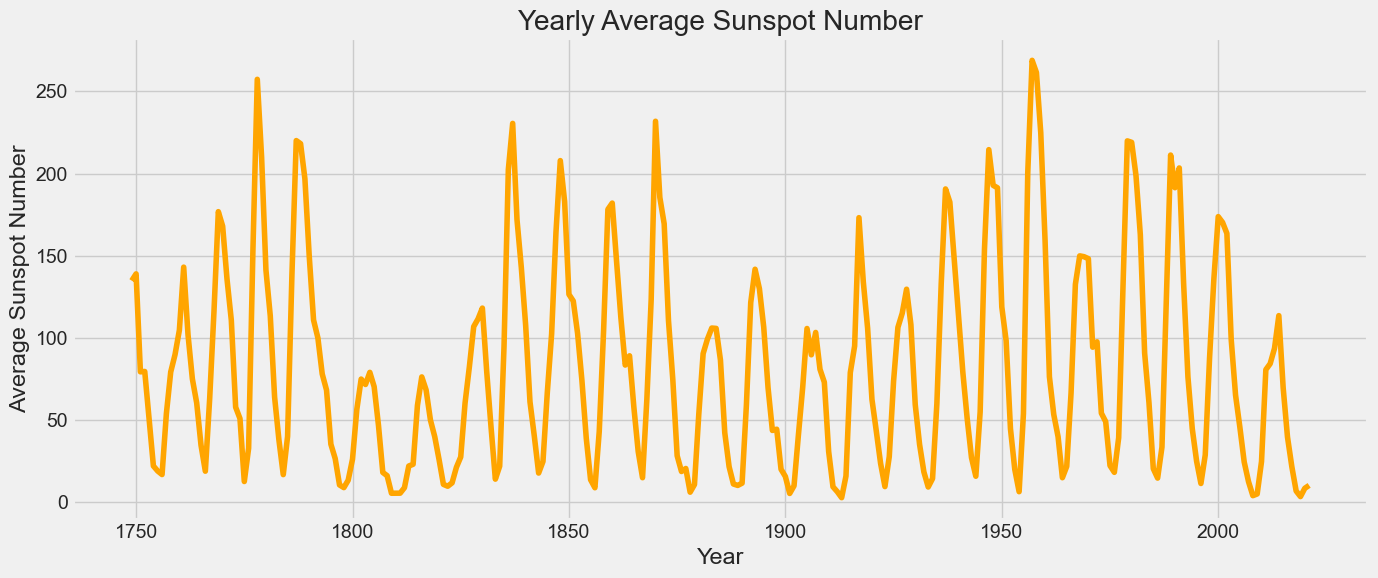

In [123]:
yearly_avg = df.groupby(df.index.year)["Sunspot"].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=yearly_avg, x="Date", y="Sunspot", color="orange")
plt.title("Yearly Average Sunspot Number")
plt.xlabel("Year")
plt.ylabel("Average Sunspot Number")
plt.grid(True)
plt.tight_layout()
plt.show()

##statistical tests

In [124]:
from scipy.stats import probplot
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy import stats

#Shapiro-Wilk test for the last 20 years(Is the data normally distributed?)

In [125]:

max_year = df.index.year.max()
df_last50 = df[df.index.year >= (max_year - 50)]
sunspot_last50 = df_last50['Sunspot'].dropna()


if len(sunspot_last50) > 5000:
    sample = sunspot_last50.sample(5000, random_state=42)
else:
    sample = sunspot_last50


stat, p_value = shapiro(sample)
print("Shapiro-Wilk Test Statistic p=:", round(stat, 4))


if p_value < 0.05:
    print("The data is NOT normally distributed  (p ≥ 0.05)")
else:
    print("The data IS normally distributed  (p < 0.05)")




Shapiro-Wilk Test Statistic p=: 0.9056
The data is NOT normally distributed  (p ≥ 0.05)


#t-test for 2 different 11-year period groups(Compare sunspot means between two time periods: 1985–1996 vs 1996–2007)

In [126]:
group1 = df[(df.index.year >= 1985) & (df.index.year <= 1996)]['Sunspot'].dropna()
group2 = df[(df.index.year >= 1996) & (df.index.year <= 2007)]['Sunspot'].dropna()

stat, p = ttest_ind(group1, group2, equal_var=False)
print(f"T-Test p-value: {p:.4f}")
if p < 0.05:
    print("Conclusion: There is a significant difference between the two periods.")
else:
    print("Conclusion: No significant difference between the two periods.")

T-Test p-value: 0.4981
Conclusion: No significant difference between the two periods.


#Poisson Distribution Check (Is the distribution Poisson-like? )

In [127]:
filtered = df[df['Sunspot'] < 100]['Sunspot'].dropna().astype(int)
mean = filtered.mean()
var = filtered.var()

print(f"Poisson Mean: {mean:.2f}, Variance: {var:.2f}")
if np.isclose(mean, var, rtol=0.2):
    print("Conclusion: The data fits a Poisson distribution.")
else:
    print("Conclusion: The data does not fit a Poisson distribution.")

Poisson Mean: 42.31, Variance: 866.21
Conclusion: The data does not fit a Poisson distribution.


#Chi-Square test

In [128]:
df['SunspotCategory'] = pd.cut(df['Sunspot'],
                               bins=[-1, 20, 70, df['Sunspot'].max()],
                               labels=["Low", "Medium", "High"])


contingency_table = pd.crosstab(df.index.month, df['SunspotCategory'])


chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("P-value:", p_value)

if p_value < 0.05:
    print("Conclusion: Monthly means are significantly different from expected uniform distribution.")
else:
    print("Conclusion: Monthly means are not significantly different from the expected values.")


Chi-Square Statistic: 9.482481669219219
P-value: 0.9904211904785045
Conclusion: Monthly means are not significantly different from the expected values.


#Pearson Correlation test

In [129]:
df['Timestamp'] = df.index.astype(np.int64) // 10**9

corr, p_value = pearsonr(df['Timestamp'], df['Sunspot'])

print(f"Pearson Correlation Coefficient: {corr:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Conclusion: No significant relationship between time and sunspot numbers.")
else:
    print("Conclusion: There is a significant linear relationship between time and sunspot numbers.")


Pearson Correlation Coefficient: 0.0179
P-value: 0.3118
Conclusion: There is a significant linear relationship between time and sunspot numbers.


#Anova(Monthly)

In [130]:
groups = [df[df["Month"] == month]["Sunspot"].dropna() for month in range(1, 13)]

f_stat, p_value = stats.f_oneway(*groups)

print("F-statistic:", f_stat)
print("P-value:", p_value)


if p_value < 0.05:
    print("Result: There is a statistically significant difference in sunspot numbers between months (p < 0.05).")
else:
    print("Result: There is no statistically significant difference between months (p ≥ 0.05).")

F-statistic: 0.10922005395236574
P-value: 0.9998721360169273
Result: There is no statistically significant difference between months (p ≥ 0.05).


##Future engineering

#Importing Libraries

In [131]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

#Initial Analisis

In [132]:
df = pd.read_csv("Sunspots.csv")
df.drop(columns='Unnamed: 0', inplace=True)
df.drop(index=df[df["Monthly Mean Total Sunspot Number"] == 0].index, inplace=True)
df.columns = ["Date", "Sunspot"]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [133]:
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Month_sin'] = np.sin(2 * np.pi * df['Month']/12)       #Cyclical encoding
df['Month_cos'] = np.cos(2 * np.pi * df['Month']/12)


df['Sunspot_lag1'] = df['Sunspot'].shift(1)
df['Sunspot_lag12'] = df['Sunspot'].shift(12)          #lag values
df['Sunspot_lag60'] = df['Sunspot'].shift(60)


df['Diff_11Year'] = df['Sunspot'] - df['Sunspot'].shift(132)

df["Year_frac"] = df.index.year + (df.index.month - 1)/12
df["Year_sin"] = np.sin(2 * np.pi * df["Year_frac"] / 11)    #11-year period (sin-cos)
df["Year_cos"] = np.cos(2 * np.pi * df["Year_frac"] / 11)


df['Rolling_11Yr'] = df['Sunspot'].rolling(window=132, min_periods=1).mean()
df['rolling_mean_12'] = df['Sunspot'].rolling(window=12).mean()                #11-year average data
df['rolling_std_12'] = df['Sunspot'].rolling(window=12).std()


df.dropna(inplace=True)

#Split the dataset into training, validation and test sets and set futures

In [134]:
features = ['Year_frac','Month_sin', 'Month_cos', 'Sunspot_lag1', 'Sunspot_lag12',  'rolling_mean_12', 'rolling_std_12','Diff_11Year','Rolling_11Yr',"Year_frac","Year_sin","Year_cos","Sunspot_lag60"]
target = 'Sunspot'

X = df[features]
y = df[target]

X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.30, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50, shuffle=False)


#Scaling

In [135]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

##Modeling

#LightGBM Regressor

In [136]:
model = LGBMRegressor()
model.fit(X_train, y_train_full)

y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 2146, number of used features: 13
[LightGBM] [Info] Start training from score 79.487372


#rmse and r^2 values of test and validation set

In [137]:
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "R2": r2}

print("Test Set:")
print(evaluate(y_test, y_pred_test))

print("Validation Set:")
print(evaluate(y_val, y_pred_val))

Test Set:
{'RMSE': np.float64(25.054357544406248), 'R2': 0.9058784061840753}
Validation Set:
{'RMSE': np.float64(16.394257924814358), 'R2': 0.9373423793634839}


#Test Set: Actual vs Predicted Graph

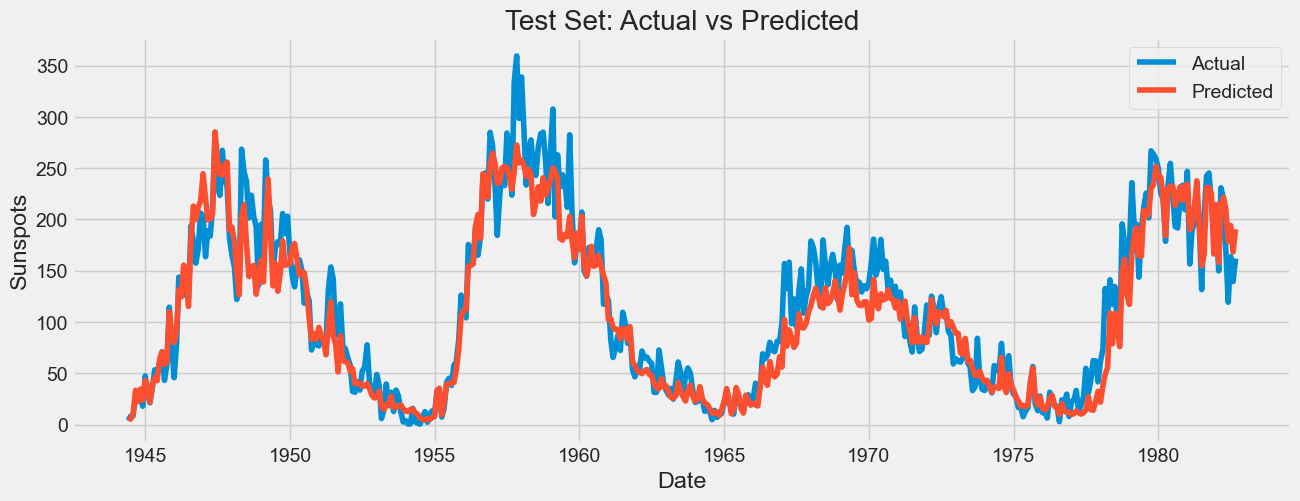

In [138]:
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_test, label='Predicted', linestyle='-')
plt.title("Test Set: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Sunspots")
plt.legend()
plt.grid(True)
plt.show()

#Validation Set: Prediction vs Actual Graph

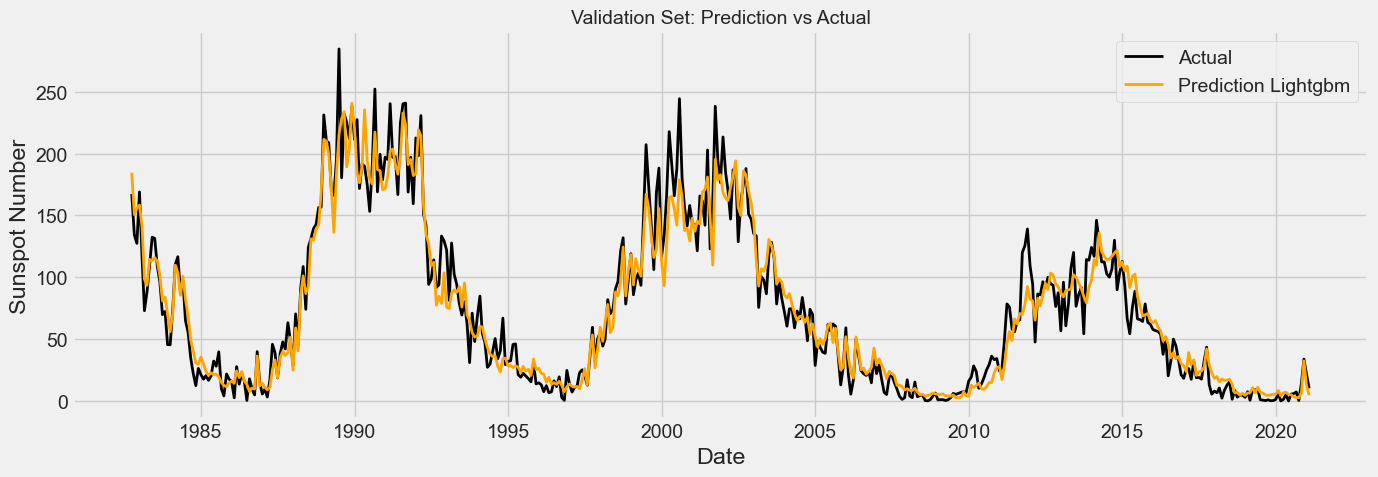

In [139]:
plt.figure(figsize=(14, 5))


plt.plot(y_val.index, y_val, label='Actual', color='black', linewidth=2)


plt.plot(y_val.index, y_pred_val, label='Prediction Lightgbm', color='orange', linestyle='-', linewidth=2)

plt.title("Validation Set: Prediction vs Actual", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sunspot Number")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Validation Prediction Graph

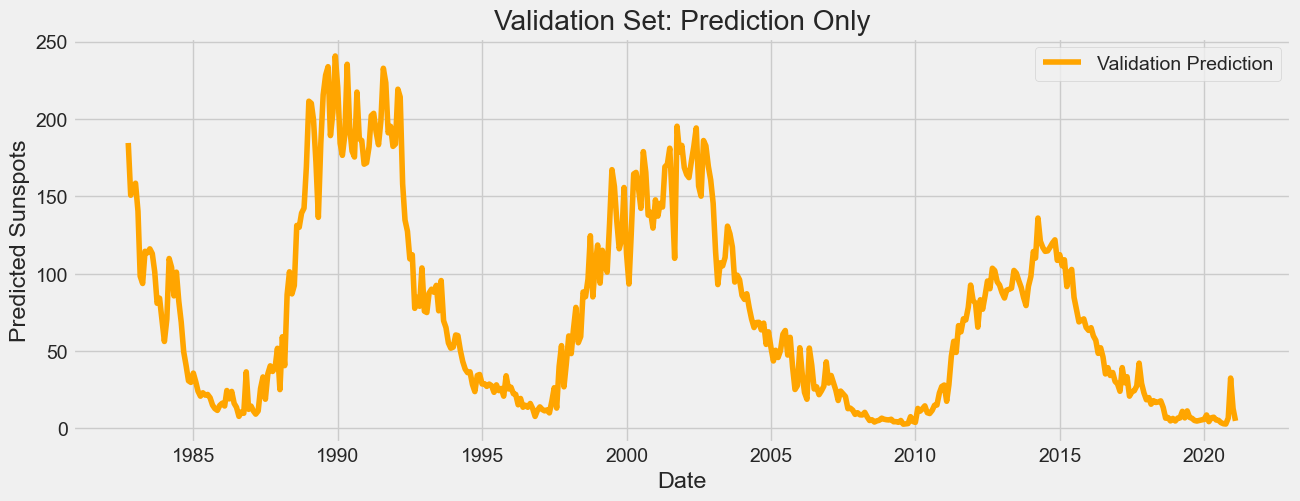

In [140]:
plt.figure(figsize=(14, 5))
plt.plot(y_val.index, y_pred_val, label='Validation Prediction', color='orange')
plt.title("Validation Set: Prediction Only")
plt.xlabel("Date")
plt.ylabel("Predicted Sunspots")
plt.legend()
plt.grid(True)
plt.show()


#test and validation values

In [141]:
print("🔸 Test Set Predictions:")
test_preds = pd.DataFrame({
    "Date": y_test.index,
    "Actual": y_test.values,
    "Predicted": y_pred_test
})
print(test_preds.tail(10))  


print("\n🔸 Validation Set Predictions (Only Predictions shown):")
val_preds = pd.DataFrame({
    "Date": y_val.index,
    "Predicted": y_pred_val
})
print(val_preds.tail(10))  

🔸 Test Set Predictions:
          Date  Actual   Predicted
450 1981-11-30   186.0  166.354216
451 1981-12-31   195.4  214.625609
452 1982-01-31   149.8  158.037855
453 1982-02-28   230.9  213.472931
454 1982-03-31   221.1  221.718960
455 1982-04-30   170.3  210.313289
456 1982-05-31   119.3  178.602771
457 1982-06-30   163.7  194.145011
458 1982-07-31   139.4  168.237018
459 1982-08-31   161.9  190.504211

🔸 Validation Set Predictions (Only Predictions shown):
          Date  Predicted
450 2020-04-30   7.251695
451 2020-05-31   5.458752
452 2020-06-30   5.228668
453 2020-07-31   3.741590
454 2020-08-31   3.024258
455 2020-09-30   2.845593
456 2020-10-31   6.691292
457 2020-11-30  32.533154
458 2020-12-31  12.858099
459 2021-01-31   4.887067


#Train and compare other models and plot graphs

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 2146, number of used features: 11
[LightGBM] [Info] Start training from score 79.487372


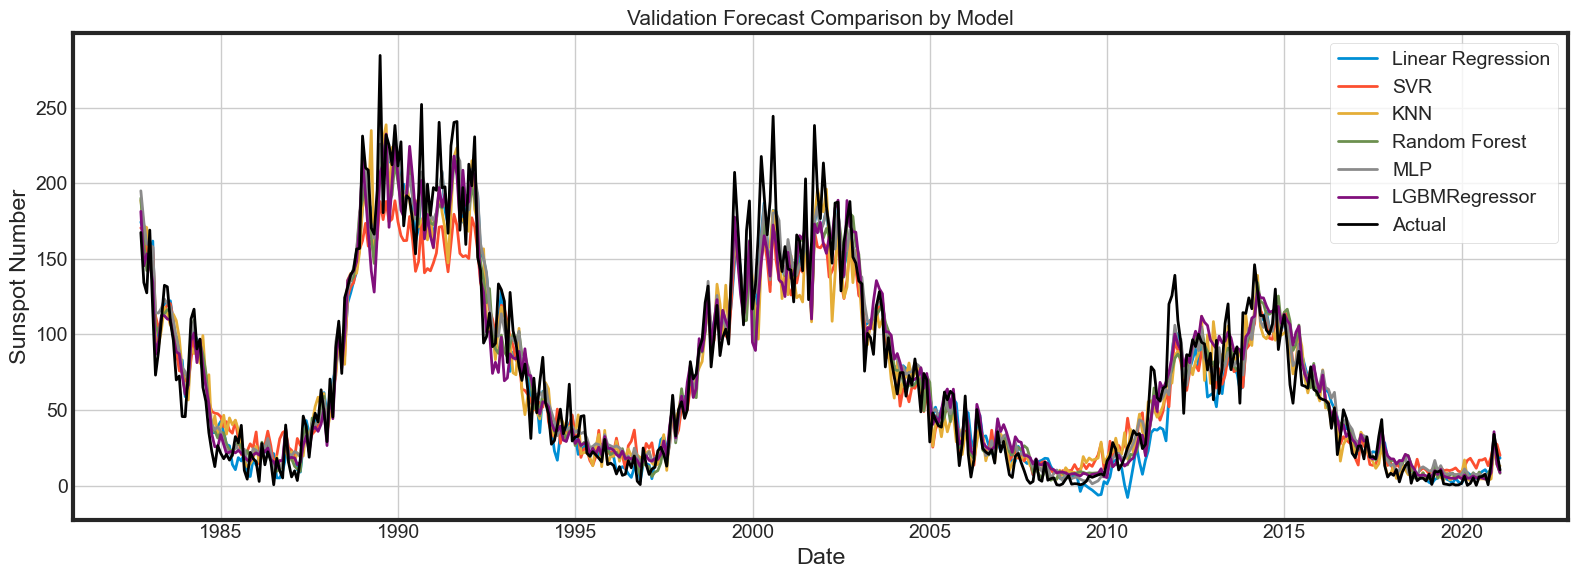

In [151]:
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(),
    "MLP": MLPRegressor(),
    "LGBMRegressor":LGBMRegressor()
}

val_preds = pd.DataFrame(index=y_val.index)
val_preds["Actual"] = y_val

for name, model in models.items():
    model.fit(X_train, y_train_full)
    val_preds[name] = model.predict(X_val)


plt.figure(figsize=(16, 6))
sns.set_style("white")

for name in val_preds.columns[1:]:
    plt.plot(val_preds.index, val_preds[name], label=name, linestyle='-', linewidth=2)

plt.plot(val_preds.index, val_preds["Actual"], label="Actual", color="black", linewidth=2)

plt.title("Validation Forecast Comparison by Model", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Sunspot Number")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Graph comparing the prediction values of all models with the actual values separately

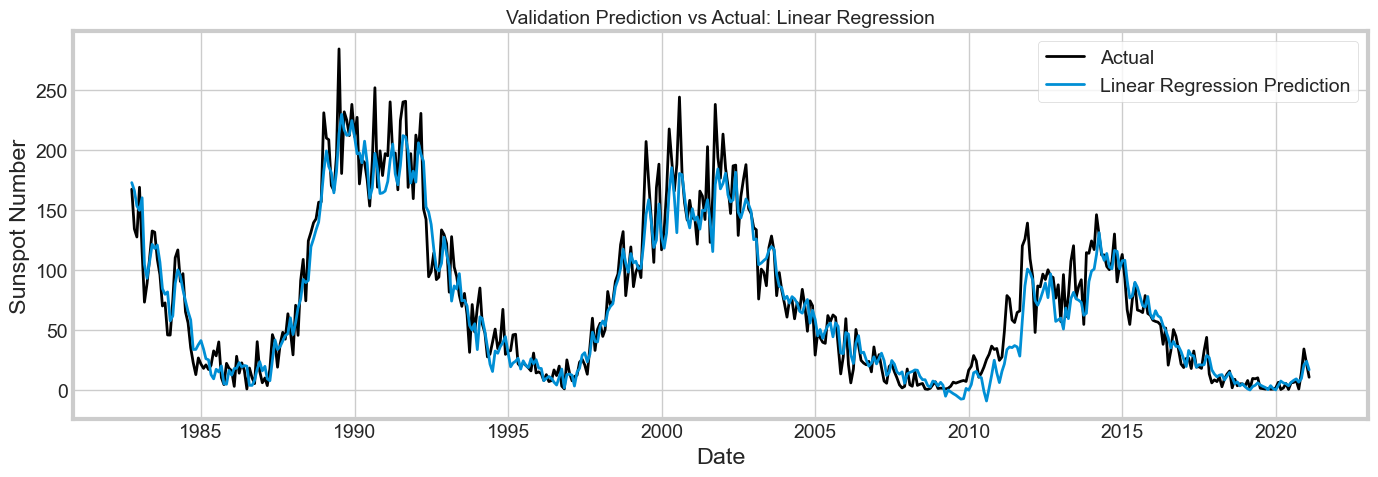

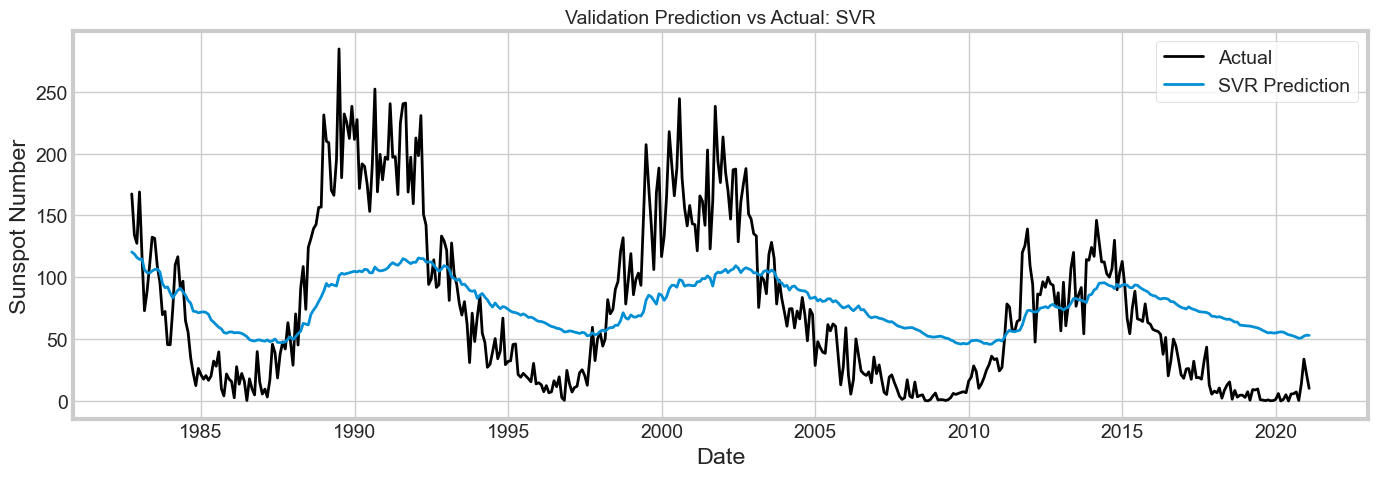

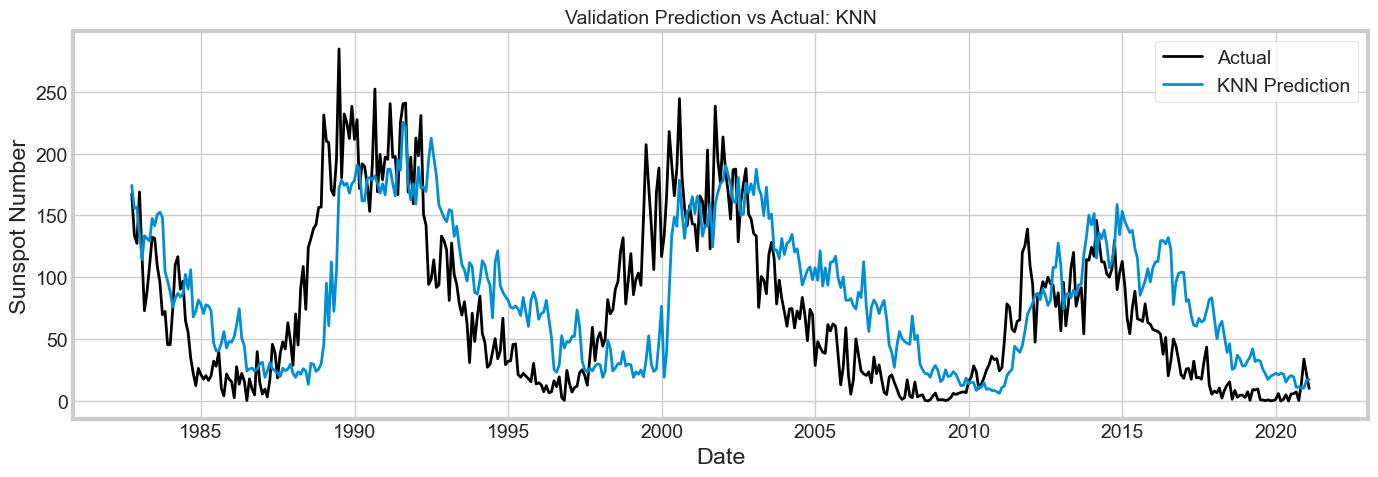

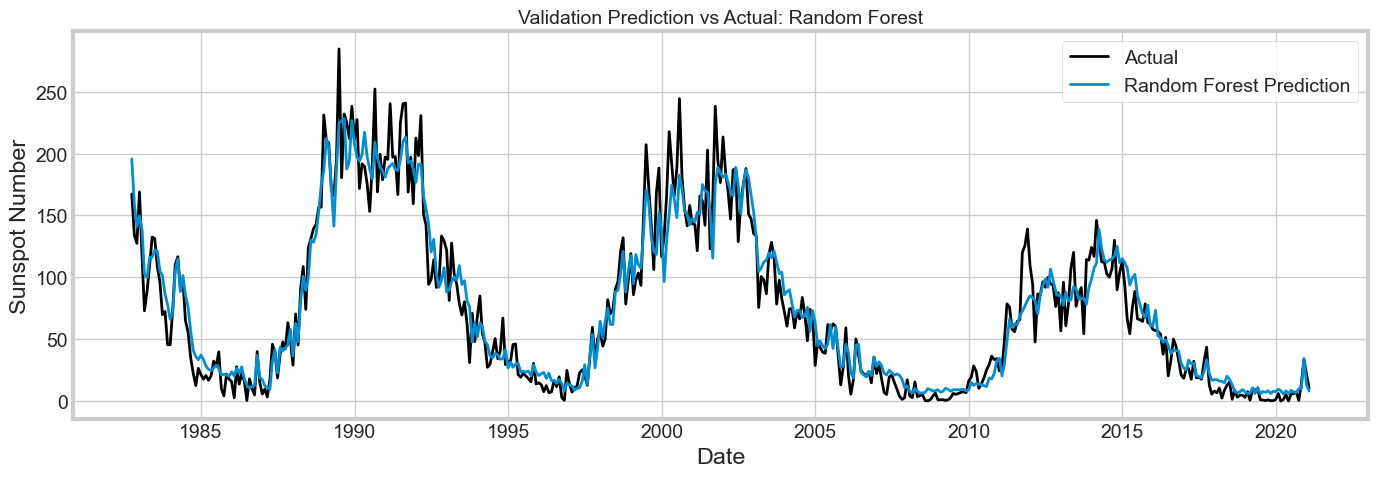

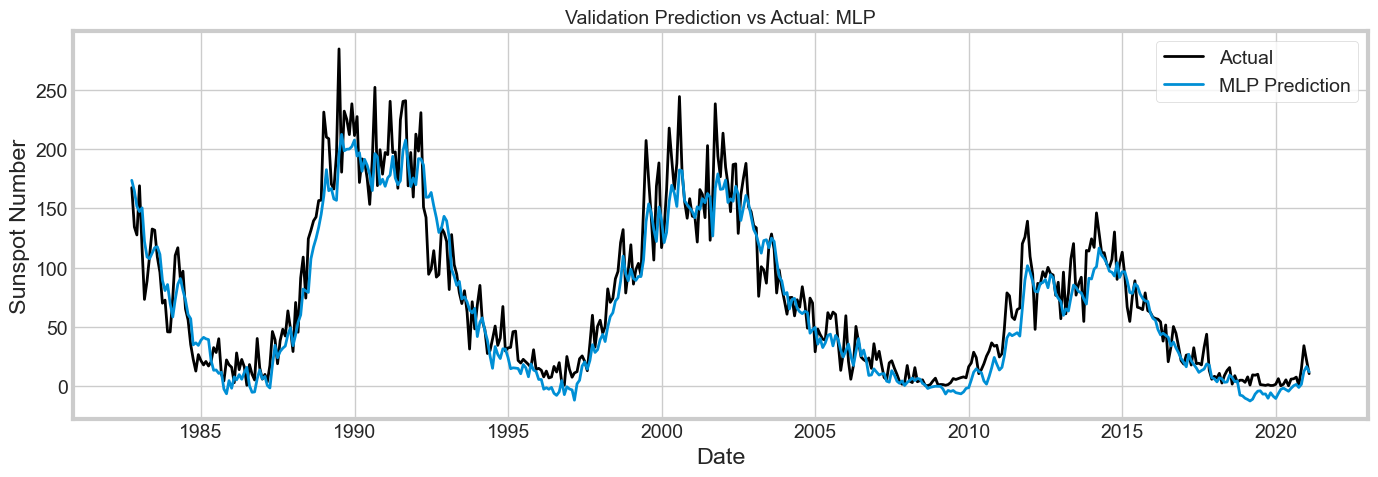

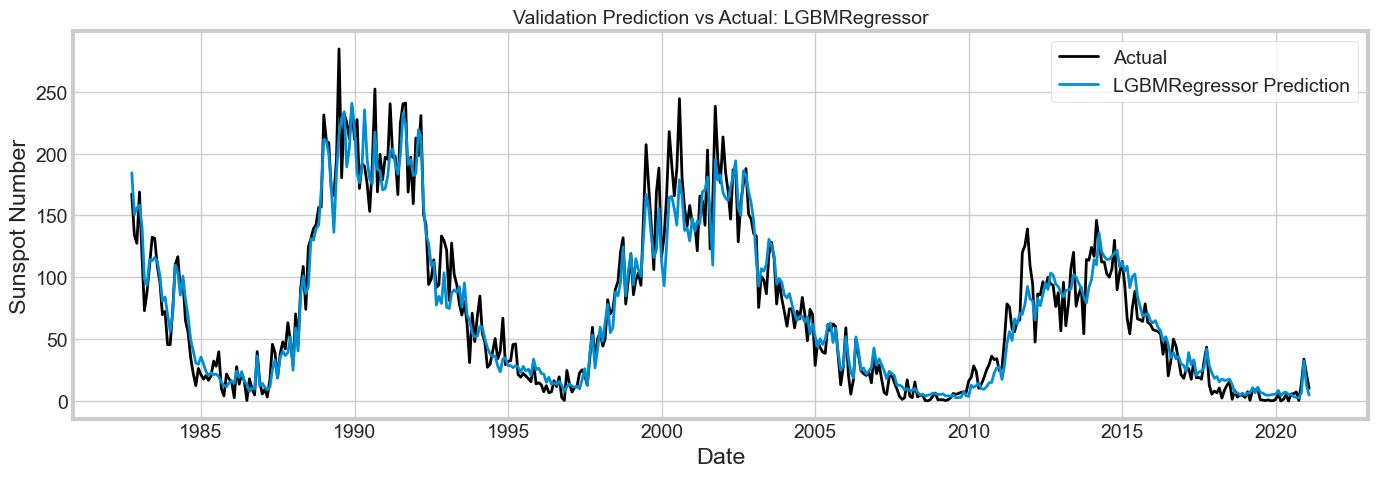

In [143]:
for name in val_preds.columns[1:]:  
    plt.figure(figsize=(14, 5))
    
    
    plt.plot(val_preds.index, val_preds["Actual"], label="Actual", color="black", linewidth=2)
    
    
    plt.plot(val_preds.index, val_preds[name], label=f"{name} Prediction", linestyle='-', linewidth=2)
    
    plt.title(f"Validation Prediction vs Actual: {name}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Sunspot Number")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#RMSE values of all models

In [144]:
rmse_scores = []


for model_name in val_preds.columns[1:]:
    rmse = np.sqrt(mean_squared_error(val_preds["Actual"], val_preds[model_name]))
    rmse_scores.append((model_name, rmse))


rmse_df = pd.DataFrame(rmse_scores, columns=["Model", "RMSE"])
rmse_df = rmse_df.sort_values(by="RMSE")

rmse_df.reset_index(drop=True, inplace=True)
print(rmse_df)


               Model       RMSE
0      LGBMRegressor  16.394258
1      Random Forest  17.439817
2  Linear Regression  18.472777
3                MLP  21.148511
4                KNN  50.533775
5                SVR  51.687583


#Plot of RMSE values of all models

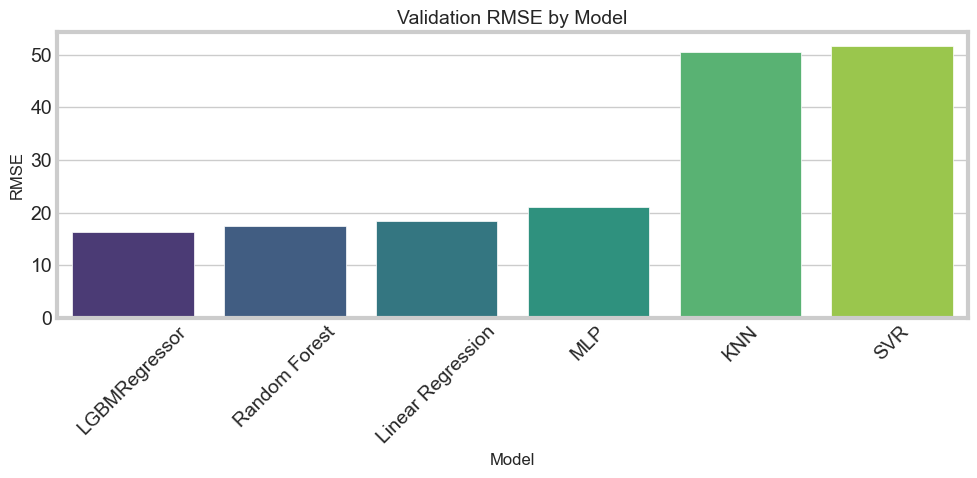

In [145]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))


sns.barplot(data=rmse_df, x="Model", y="RMSE", palette="viridis")

plt.title("Validation RMSE by Model", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#choosing the best model

In [146]:
best_model_name = rmse_df.iloc[0]["Model"]
print(f"Best Model: {best_model_name}")


Best Model: LGBMRegressor


#feature importance graph of the best model

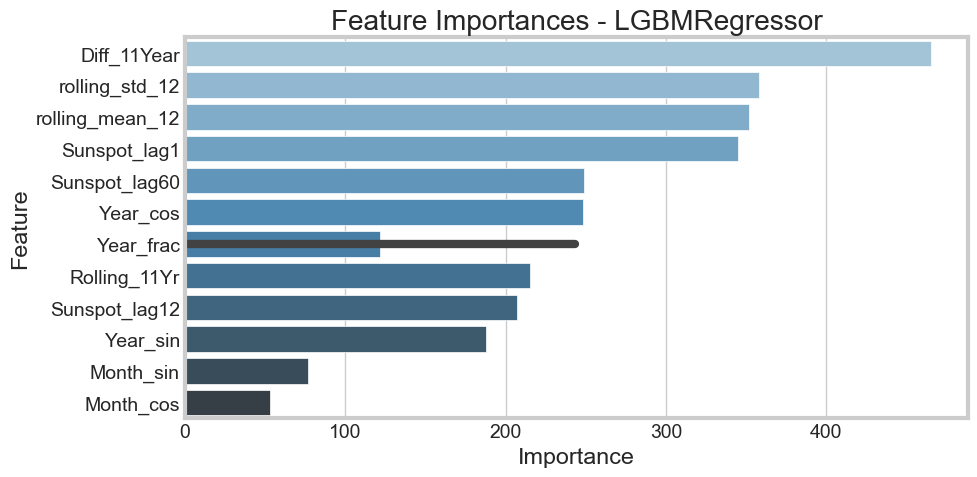

In [147]:
feature_names = X.columns.tolist()



best_model = models[best_model_name]

if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
elif hasattr(best_model, "coef_"):
    importances = np.abs(best_model.coef_)
else:
    importances = None


if importances is not None:
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=importance_df, x="Importance", y="Feature", palette="Blues_d")
    plt.title(f"Feature Importances - {best_model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

#Detailed graph comparing all models with actual values

In [148]:
import plotly.express as px
import plotly.io as pio




val_preds_long = val_preds.reset_index().melt(
    id_vars="Date",
    var_name="Model",
    value_name="Prediction"
)


color_map = {
    "Actual": "black",
    "Linear Regression": "#faf602",  
    "SVR": "#03f72c",                
    "KNN": "purple",                
    "Random Forest": "#00fcfc",      
    "MLP": "#0113b9",
    "LGBMRegressor":"red"                 
}


fig = px.line(
    val_preds_long,
    x="Date",
    y="Prediction",
    color="Model",
    title="Validation Predictions vs Actual (Styled)",
    labels={"Prediction": "Sunspot Number"},
    color_discrete_map=color_map
)


fig.for_each_trace(
    lambda trace: trace.update(line=dict(width=5)) if trace.name == "Actual"
    else trace.update(line=dict(width=2))
)


fig.update_layout(
    template="plotly_white",
    legend_title="Models",
    font=dict(size=14)
)

fig.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2316
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 11
[LightGBM] [Info] Start training from score 94.525435


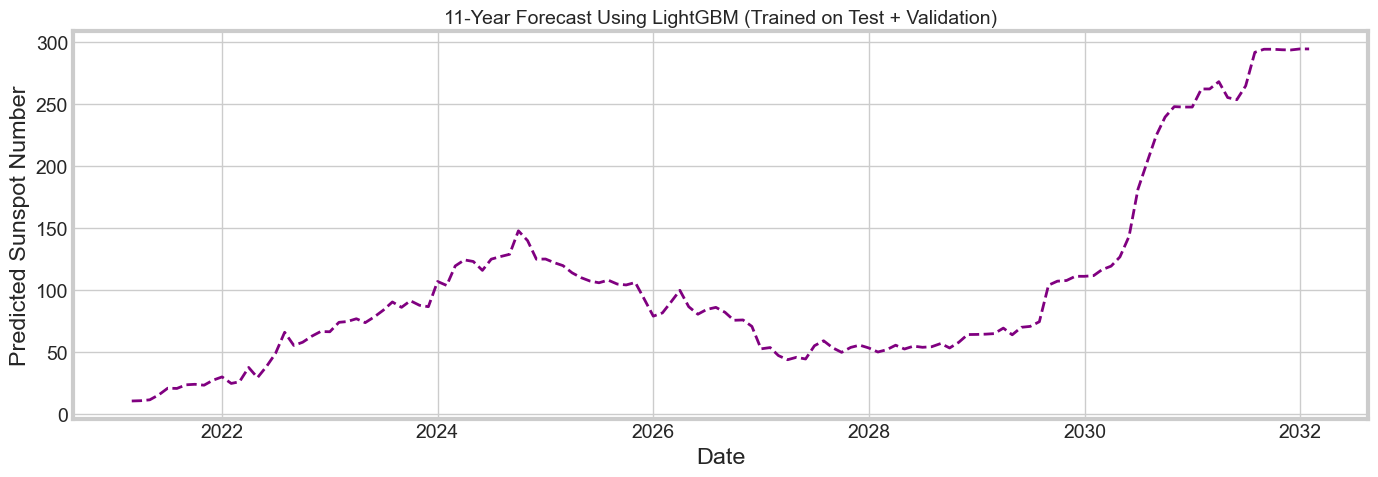

In [149]:
import lightgbm as lgb
features = [
    'Month_sin', 'Month_cos',
    'Sunspot_lag1', 'Sunspot_lag12', 'Sunspot_lag60',
    'Diff_11Year',
    'rolling_mean_12', 'rolling_std_12',
    'Year_sin', 'Year_cos', 'Rolling_11Yr'
]


X = df[features]
y = df["Sunspot"]


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, shuffle=False)


X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50, shuffle=False)


X_future_train = pd.concat([X_test, X_val])
y_future_train = pd.concat([y_test, y_val])


scaler = MinMaxScaler()
X_future_train_scaled = scaler.fit_transform(X_future_train)


model_lgb = lgb.LGBMRegressor()
model_lgb.fit(X_future_train_scaled, y_future_train)


n_future = 132
last_date = df.index.max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_future, freq='MS')

future_df = df.copy()
future_preds = []

for date in future_dates:
    month = date.month
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    lag_1 = future_df.iloc[-1]["Sunspot"]
    lag_12 = future_df.iloc[-12]["Sunspot"]
    lag_60 = future_df.iloc[-60]["Sunspot"]
    diff_11y = lag_1 - future_df.iloc[-132]["Sunspot"]
    roll_mean = future_df["Sunspot"].rolling(window=12).mean().iloc[-1]
    roll_std = future_df["Sunspot"].rolling(window=12).std().iloc[-1]
    year_frac = date.year + (date.month - 1)/12
    year_sin = np.sin(2 * np.pi * year_frac / 11)
    year_cos = np.cos(2 * np.pi * year_frac / 11)
    rolling_11yr = future_df["Sunspot"].rolling(window=132).mean().iloc[-1]

    row = pd.DataFrame([[
        month_sin, month_cos, lag_1, lag_12, lag_60,
        diff_11y, roll_mean, roll_std, year_sin, year_cos, rolling_11yr
    ]], columns=features)

    row_scaled = scaler.transform(row)
    pred = model_lgb.predict(row_scaled)[0]
    future_preds.append(pred)

    future_df.loc[date] = {
        'Sunspot': pred,
        'Month': month,
        'Day': 1,
        'Month_sin': month_sin,
        'Month_cos': month_cos,
        'Sunspot_lag1': lag_1,
        'Sunspot_lag12': lag_12,
        'Sunspot_lag60': lag_60,
        'Diff_11Year': diff_11y,
        'rolling_mean_12': roll_mean,
        'rolling_std_12': roll_std,        
        'Year_sin': year_sin,
        'Year_cos': year_cos,
        'Rolling_11Yr': rolling_11yr
    }


future_forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted": future_preds
}).set_index("Date")

plt.figure(figsize=(14, 5))
plt.plot(future_forecast_df.index, future_forecast_df["Predicted"], color="purple", linestyle="--", linewidth=2)
plt.title("11-Year Forecast Using LightGBM (Trained on Test + Validation)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Predicted Sunspot Number")
plt.grid(True)
plt.tight_layout()
plt.show()